In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import os, sys
import numpy as np
from time import time
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle, Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.facecolor'] = 'white'

import proper
paospath = "~/git/PAOS"
if not os.path.expanduser(paospath) in sys.path:
    sys.path.append( os.path.expanduser(paospath) )
import paos
from paos import logger

In [12]:
def extent(wfarr, dx, dy):
    return (-wfarr.shape[1] // 2 * dx, (wfarr.shape[1] // 2 - 1) * dx,
            -wfarr.shape[0] // 2 * dy, (wfarr.shape[0] // 2 - 1) * dy)

def push_results(wfo, init=False):
    if init:
        fratio = proper.prop_get_fratio(wfo)
        retval = {'fratio': fratio if fratio < 1e9 else np.inf}
    else:
        retval = {'amplitude': proper.prop_get_amplitude(wfo),
                  'wz': proper.prop_get_beamradius(wfo),
                  'distancetofocus': proper.prop_get_distancetofocus(wfo),
                  'phase': -proper.prop_get_phase(wfo),  # phase angles in proper are defined in the opposite sense
                  'dx': proper.prop_get_sampling(wfo),
                  'dy': proper.prop_get_sampling(wfo),
                  'wfo': proper.prop_get_wavefront(wfo),
                  'wl': proper.prop_get_wavelength(wfo),
                  }
        retval['extent'] = extent(retval['wfo'], retval['dx'], retval['dy'])
    return retval

def hubble_simple(wavelength, gridsize, PASSVALUE={}):

    proper.print_it = True

    start_time = time()

    # Define entrance aperture diameter and other quantities
    diam = 2.4  # telescope diameter in meters
    fl_pri = 5.52085  # HST primary focal length (m)
    d_pri_sec = 4.907028205  # primary to secondary separation (m)
    fl_sec = -0.6790325  # HST secondary focal length (m)
    d_sec_to_focus = 6.3919974  # nominal distance from secondary to focus
    beam_ratio = 0.25  # initial beam width/grid width

    # Define the wavefront
    wfo = proper.prop_begin(diam, wavelength, gridsize, beam_ratio)

    # Define a circular aperture
    proper.prop_circular_aperture(wfo, diam / 2)  # HST aperture (primary mirror)
    proper.prop_circular_obscuration(wfo, 0.078, -0.9066, -0.5538)  # primary mirror pad 1
    proper.prop_circular_obscuration(wfo, 0.078, 0., 1.0705)  # primary mirror pad 2
    proper.prop_circular_obscuration(wfo, 0.078, 0.9127, -0.5477)  # primary mirror pad 3
    proper.prop_circular_obscuration(wfo, 0.396)  # secondary mirror obscuration
    proper.prop_rectangular_obscuration(wfo, 0.0264, 2.5)  # secondary vane (vertical)
    proper.prop_rectangular_obscuration(wfo, 2.5, 0.0264)  # secondary vane (horizontal)

    # Define entrance
    proper.prop_define_entrance(wfo)

    # Define a lens
    PASSVALUE[8] = push_results(wfo, init=True)
    proper.prop_lens(wfo, fl_pri, "primary")  # primary mirror
    PASSVALUE[8].update(push_results(wfo))

    # Propagate the wavefront
    proper.prop_propagate(wfo, d_pri_sec, "secondary")

    PASSVALUE[10] = push_results(wfo, init=True)
    proper.prop_lens(wfo, fl_sec, "secondary")
    PASSVALUE[10].update(push_results(wfo))

    PASSVALUE[11] = push_results(wfo, init=True)
    proper.prop_propagate(wfo, d_sec_to_focus, "HST focus", TO_PLANE=False)
    PASSVALUE[11].update(push_results(wfo))

    # End
    (wfo, sampling) = proper.prop_end(wfo)

    end_time = time()

    if proper.print_it:
        print("Total elapsed time (seconds) = %8.4f" %(end_time - start_time))

    return PASSVALUE

def simple_plot(fig, axis, idx, item, ima_scale, keyword=None, returns=False, surface_zoom=dict()):
    """
    Given the POP simulation output dict, plots the squared amplitude of the
    wavefront at the given optical surface.

    Parameters
    ----------
    fig: `~matplotlib.figure.Figure`
        instance of matplotlib figure artist
    axis: `~matplotlib.axes.Axes`
        instance of matplotlib axes artist
    idx: int
        optical surface index
    item: dict
        optical surface dict
    ima_scale: str
        plot color map scale, can be either 'linear' or 'log'
    keyword:
        custom keyword to plot. Ex: amplitude, phase. Defaults to None.
    returns:
        if True, returns ima
    surface_zoom: dict
        dict containing the zoom scale to display the plot

    Returns
    -------
    None or array
        displays the plot output or stores it to the indicated plot path.
        If indicated, returns ima array.

    """
    logger.trace('plotting S{:02d}'.format(idx))

    if item['wz'] < 0.005:
        # Use microns
        scale = 1.0e6
        unit = 'micron'
    else:
        # Use mm
        scale = 1.0e3
        unit = 'mm'

    if keyword is not None:
        ima = np.ma.masked_array(data=item[keyword])
    else:
        if 'psf' in item.keys():
            ima = np.ma.masked_array(data=item['psf'], mask=item['amplitude'] <= 0.0)
        else:
            ima = np.ma.masked_array(data=item['amplitude'] ** 2, mask=item['amplitude'] <= 0.0)
        power = ima.sum()

    if ima_scale == 'log':
        ima /= ima.max()
        im = axis.imshow(10 * np.ma.log10(ima), origin='lower',
                         vmin=-20, vmax=0)
        cbar_label = 'power/pix [db]'
    elif ima_scale == 'linear':
        im = axis.imshow(ima, origin='lower')
        cbar_label = 'power/pix'
    else:
        logger.error('ima_scale shall be either log or linear')
        raise KeyError('ima_scale shall be either log or linear')

    cax = make_axes_locatable(axis).append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label(cbar_label)

    if item['aperture'] is not None:
        x, y = item['aperture'].positions
        dx, dy = item['dx'], item['dy']
        shapex = item['wfo'].shape[1]
        shapey = item['wfo'].shape[0]
        xy = scale * (x - shapex // 2) * dx, scale * (y - shapey // 2) * dy

        if hasattr(item['aperture'], 'w') and hasattr(item['aperture'], 'h'):
            w = item['aperture'].w
            h = item['aperture'].h
            wx = w * dx * scale
            wy = h * dy * scale
            xy = xy[0] - wx / 2, xy[1] - wy / 2
            ap = Rectangle(xy, wx, wy, ec='r', lw=5, fill=False)

        elif hasattr(item['aperture'], 'a') and hasattr(item['aperture'], 'b'):
            a = item['aperture'].a
            b = item['aperture'].b
            wx = 2 * a * dx * scale
            wy = 2 * b * dy * scale
            ap = Ellipse(xy, wx, wy, ec='r', lw=5, fill=False)

        axis.add_patch(ap)

    im.set_extent(np.array(item['extent']) * scale)

    beamradius = scale * item['wz']
    airyradius = 1.22 * scale * item['fratio'] * item['wl']

    if np.isfinite(airyradius):
        for airy_scale in [1.22, 2.23, 3.24, 4.24, 5.24]:
            arad = airyradius * airy_scale / 1.22
            aper = Ellipse((0, 0), width=2 * arad, height=2 * arad, ec='k', lw=5, fill=False, alpha=0.5)
            axis.add_patch(aper)

    if np.isfinite(airyradius) and beamradius < airyradius and ('ABCDt' not in item.keys() or (item['ABCDt']() != np.eye(2)).all()):
            plotscale = 5.24 * airyradius / 1.22  # 5th Airy null
    elif not item['aperture'] is None:
        plotscale = max(wx / 2, wy / 2)
    else:
        plotscale = beamradius

    if idx in surface_zoom.keys():
        zoomout = surface_zoom[idx]
    else:
        zoomout = 1

    ima_zoom = zoomout * plotscale
    axis.set_xlim(-ima_zoom, ima_zoom)
    axis.set_ylim(-ima_zoom, ima_zoom)
    axis.grid()

    if keyword is not None:
            axis.set_title(keyword)
    else:
        axis.set_title(r"S{:02d} | F#{:.2f} | w{:.2f}{:s} | $\lambda${:3.2f}$\mu$m | P{:2.0f}%".format(
            idx, item['fratio'], scale * item['wz'], unit, 1.0e6 * item['wl'], 100 * power))
    axis.set_xlabel(unit)
    axis.set_ylabel(unit)

    if returns:
        return ima[ima.shape[0]//2-int(ima_zoom): ima.shape[0]//2+int(ima_zoom),
                   ima.shape[1]//2-int(ima_zoom): ima.shape[1]//2+int(ima_zoom)]

Applying lens at primary
Propagating to secondary
Applying lens at secondary
Propagating to HST focus
Total elapsed time (seconds) =   1.0852


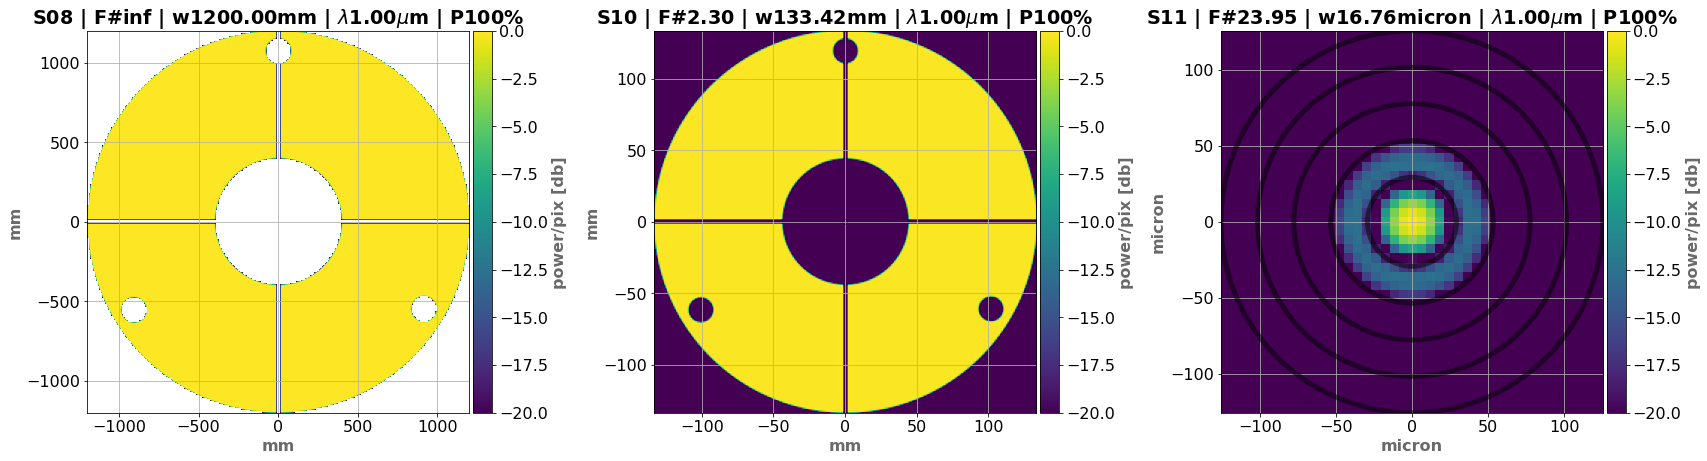

In [13]:
retval_proper = hubble_simple(1.00e-6, 1024, PASSVALUE = {})

fig, axs = plt.subplots(1, 3, figsize=(24, 7))
plt.subplots_adjust(wspace=0.5)

for i, (key, item) in enumerate(retval_proper.items()):
    simple_plot(fig=fig, axis=axs[i], idx=key, item=item, ima_scale='log')

plt.tight_layout()
plt.savefig(os.path.join('../output/plots', 'proper_hst.png'), format='png', bbox_inches='tight', dpi=150)

paos - INFO - Parse lens file
paos - INFO - Set up the POP
paos - INFO - Run the POP
paos - INFO - Start POP using a single thread...
100%|██████████| 1/1 [00:00<00:00,  1.32it/s]
paos - INFO - POP completed in    0.8s
paos - INFO - Save POP simulation output .h5 file to ../output/Hubble.h5
paos - INFO - Saving ../output/Hubble.h5 started...
paos - INFO - Remove old file
paos - INFO - Saving ended.


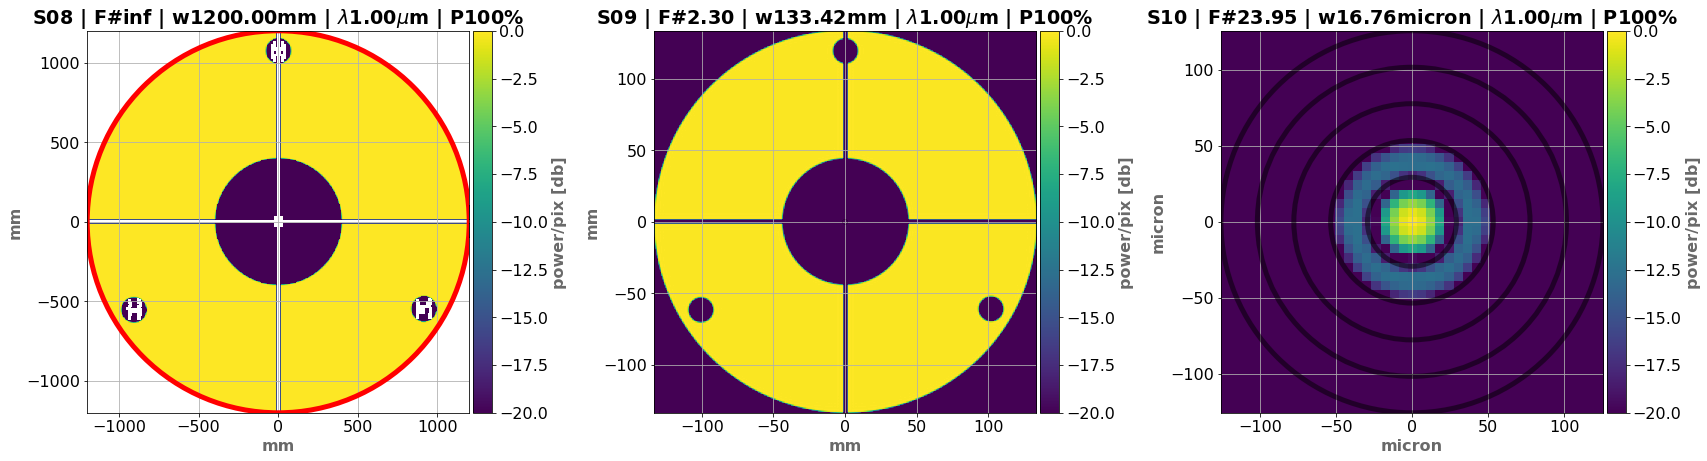

In [14]:
from paos.paos_pipeline import pipeline

retval_paos = pipeline(passvalue={'conf': '../lens data/Hubble_simple.ini',
                                  'output': '../output/Hubble.h5',
                                  'return': True,
                                  'debug': False})

fig, axs = plt.subplots(1, 3, figsize=(24, 7))
plt.subplots_adjust(wspace=0.5)

for i, (key, item) in enumerate(retval_paos.items()):
    simple_plot(fig=fig, axis=axs[i], idx=key, item=item, ima_scale='log')

plt.tight_layout()
plt.savefig(os.path.join('../output/plots', 'paos_hst.png'), format='png', bbox_inches='tight', dpi=150)

In [15]:
retval_paos[10]['phase'] *= -1
retval_diff = deepcopy(retval_proper)

for key in ['amplitude', 'phase', 'wfo']:
    retval_diff[11][key] = retval_paos[10][key] - retval_proper[11][key]

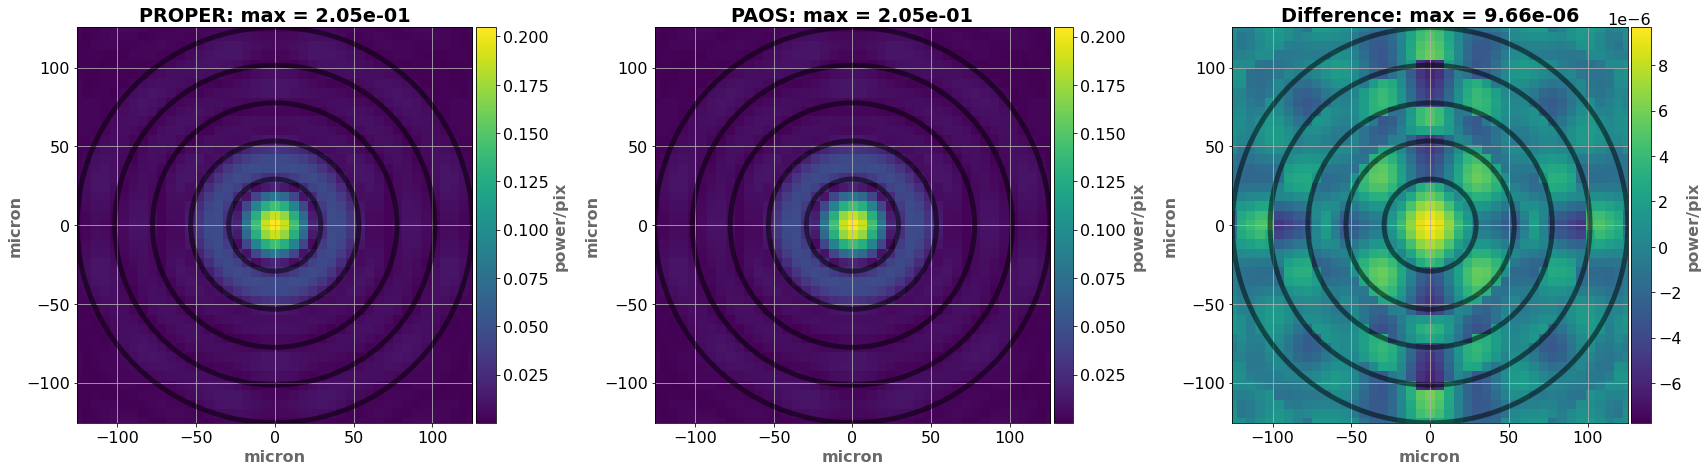

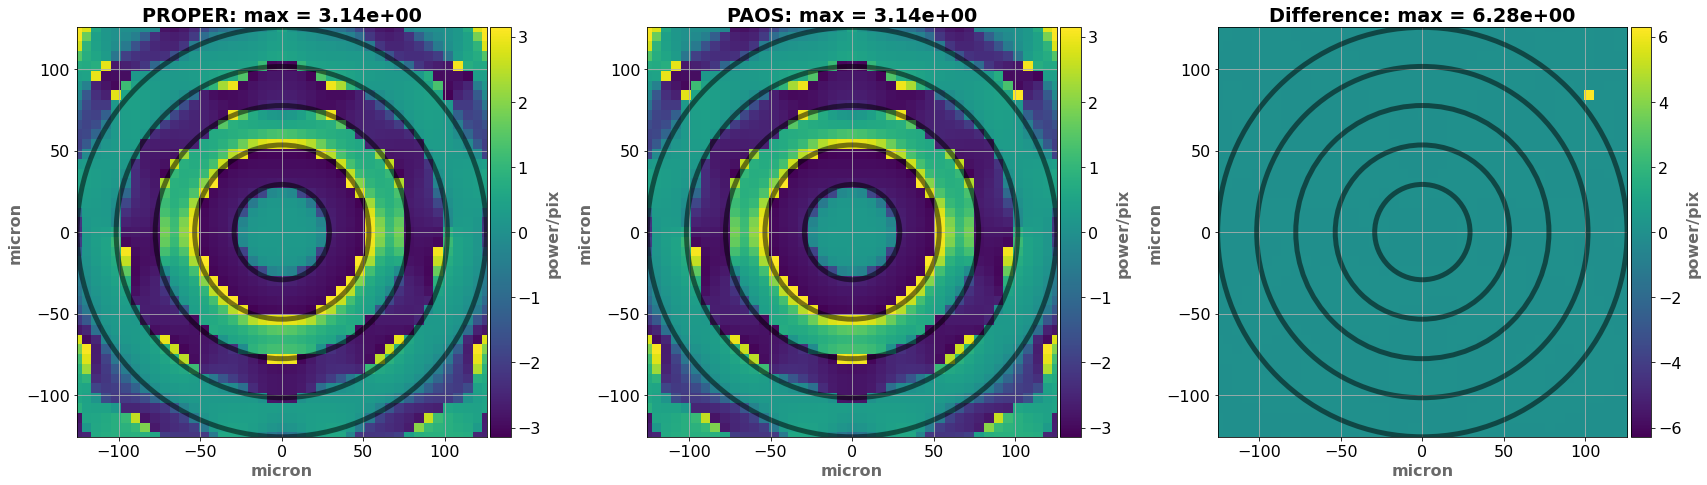

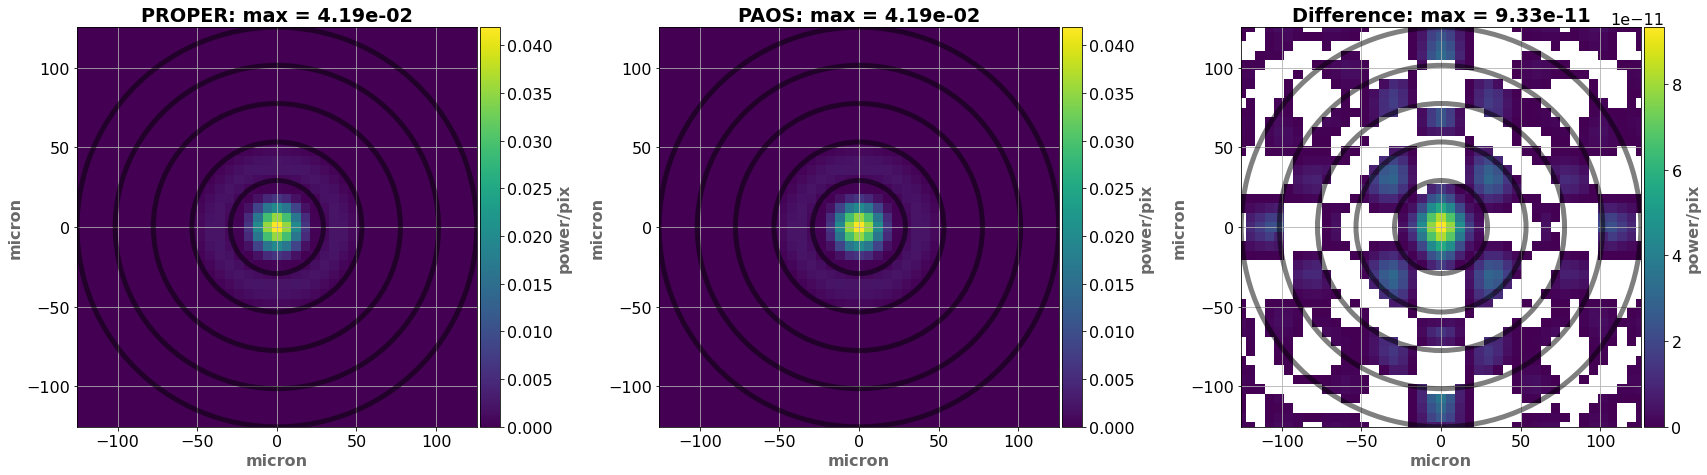

In [17]:
keywords = ['amplitude', 'phase', 'psf']

for obj in keywords:

    fig, axs = plt.subplots(1, 3, figsize=(24, 7))
    plt.subplots_adjust(wspace=0.5)
    title = '{} comparison'.format(obj.capitalize())
    # plt.suptitle(title, fontsize=24)

    for i, key in enumerate(['PROPER', 'PAOS', 'Difference']):

        if key == 'PROPER':
            Imsurf = 11
            item = retval_proper[Imsurf]
        elif key == 'PAOS':
            Imsurf = 10
            item = retval_paos[Imsurf]
        else:
            Imsurf = 11
            item = retval_diff[Imsurf]

        keyword = obj if obj != 'psf' else None

        ima = simple_plot(fig=fig, axis=axs[i], idx=Imsurf, item=item, keyword=keyword, returns=True, ima_scale='linear')
        axs[i].set_title('{}: max = {:.2e}'.format(key, ima.max()))

    plt.tight_layout()
    figname = ''.join([title.replace(' ', '_'), '.png'])
    plt.savefig(os.path.join('../output/plots', figname), format='png', bbox_inches='tight', dpi=150)